In [14]:
import warnings
warnings.filterwarnings(action='ignore')

import random
import pandas as pd
import numpy as np

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [15]:
from dataset import get_data
import matplotlib.pyplot as plt

In [16]:
DATA_PATH = "../data/kaggle_data/"

In [17]:
# make dataset

def data_extract(df_dict, df, name, cols):
       for col in cols:
              df_dict[f"{name}_{col}"] = df.loc[df[col] != 0, col]
       return df_dict

train_data_list = []
val_data_list = []

pmj_df = pd.read_csv(DATA_PATH + "pjm_elec_daily.csv")
pmj_cols = ['AEP', 'COMED', 'DAYTON', 'DEOK', 'DOM', 'DUQ', 'FE', 'NI', 'PJME', 'PJMW'] # 'PJM_Load', 'EKPC'

df_dict = {}

df_dict = data_extract(df_dict, pmj_df, 'PMJ', pmj_cols)

for df_name in df_dict:
    df = df_dict[df_name]
    train_data, val_data, scaler = get_data(df, False)
    print(df_name, len(train_data), len(val_data))
    train_data_list.append((train_data, df_name, scaler))
    val_data_list.append((val_data, df_name, scaler))

PMJ_AEP 4044 1011
PMJ_COMED 2217 555
PMJ_DAYTON 4044 1011
PMJ_DEOK 1925 482
PMJ_DOM 3874 969
PMJ_DUQ 3970 993
PMJ_FE 2096 525
PMJ_NI 1949 488
PMJ_PJME 4847 1212
PMJ_PJMW 4775 1194


In [18]:
tmp_data, t, scaler = train_data_list[0]
tmp_data = pd.DataFrame(tmp_data)
tmp_data.head()

,0
0,328544.0
1,311997.0
2,293450.0
3,343417.0
4,346553.0


In [7]:
tmp_diff1 = tmp_data.diff().dropna()
tmp_diff1.head()

,0
1,-16547.0
2,-18547.0
3,49967.0
4,3136.0
5,-358.0


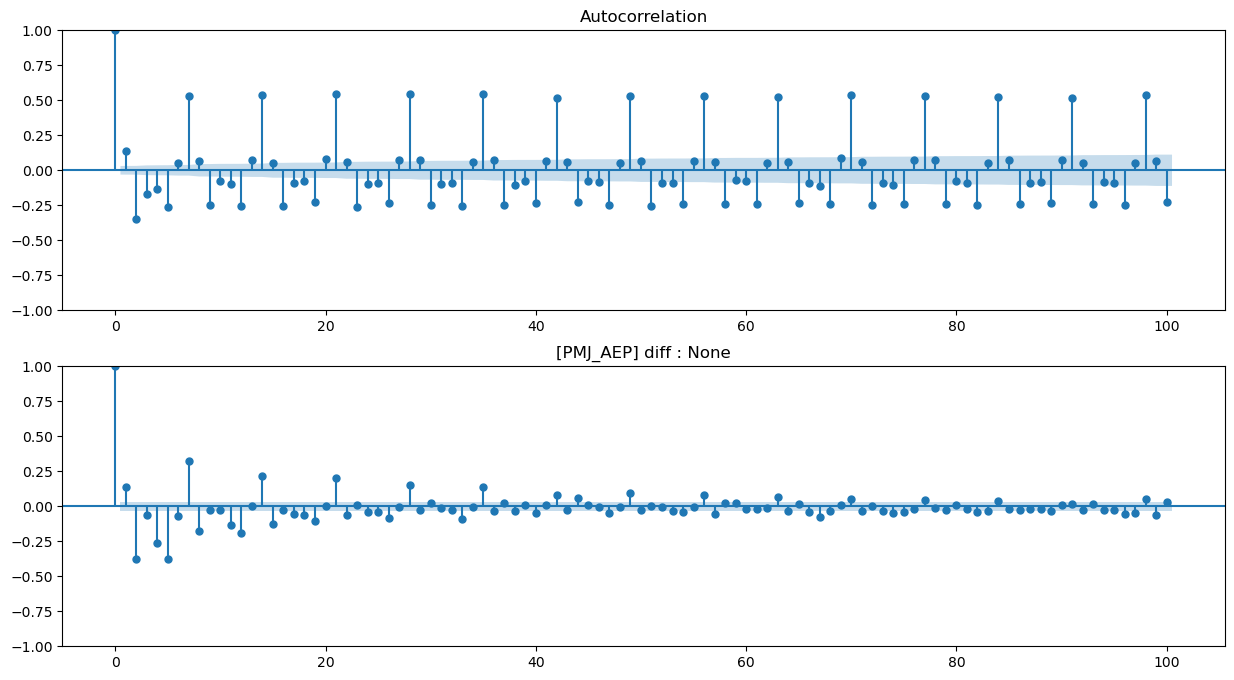

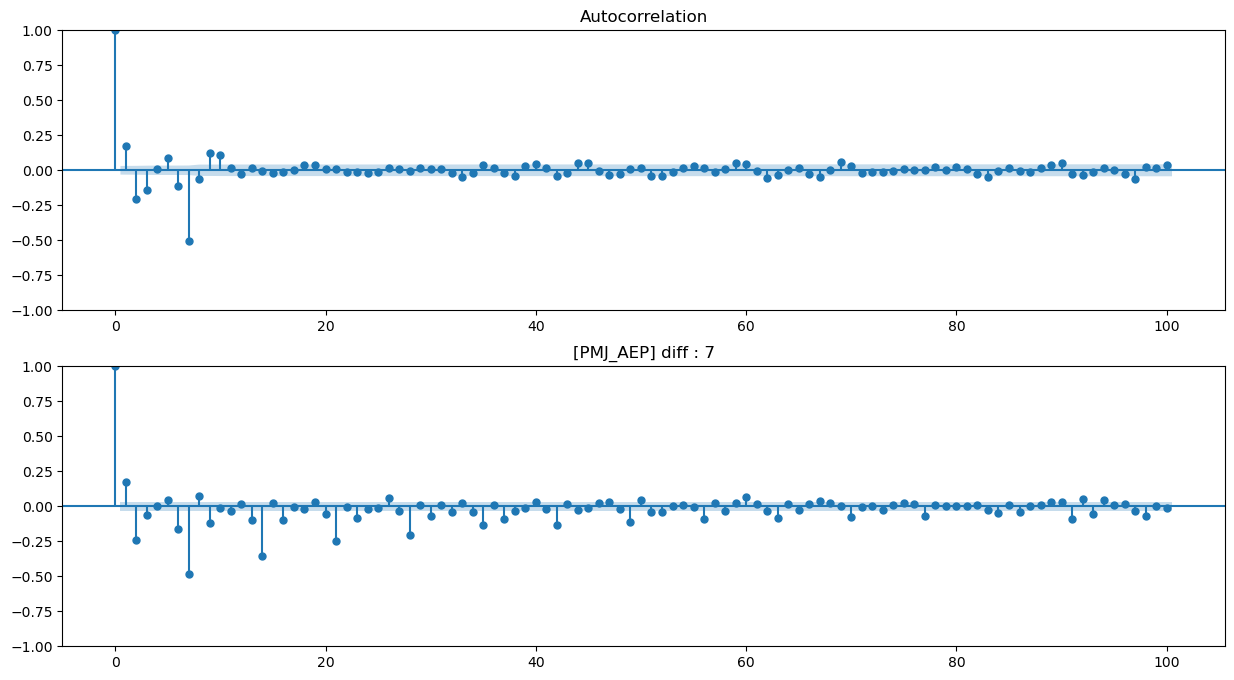

In [7]:
from util import plot_ac
diff = [7]

plot_ac(tmp_diff1, t, diff, data=False, acf=True, pacf=True, lags=100)

In [33]:
tmp_data.tail()

,0
4039,312426.0
4040,284185.0
4041,273661.0
4042,318263.0
4043,333055.0


In [19]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA(p, d, q)(P, D, Q, S)

orders = [((7, 1, 1), (1, 1, 0, 12))]
bset_AIC = float('inf')
for order in orders:
    model = ARIMA(tmp_data[-100:], order=order[0], seasonal_order=order[1])
    model_fit = model.fit()

    print(model_fit.summary())

    if bset_AIC > model_fit.aic:
        best_model = model_fit
        best_AIC = model_fit.aic

forecast = best_model.forecast(steps=60)
print(forecast)

                                     SARIMAX Results                                     
Dep. Variable:                                 0   No. Observations:                  100
Model:             ARIMA(7, 1, 1)x(1, 1, [], 12)   Log Likelihood               -1007.691
Date:                           Mon, 20 May 2024   AIC                           2035.381
Time:                                   21:26:44   BIC                           2060.040
Sample:                                        0   HQIC                          2045.311
                                           - 100                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0907      0.301      0.301      0.763      -0.500       0.681
ar.L2         -0.2210      0.055     -4.015

In [54]:
from pmdarima.arima import auto_arima

auto_arima_model = auto_arima(tmp_data[-200:],
                              # start_p=3,
                              # start_q=3,
                              max_p=7,
                              max_q=7,
                              max_d=7,
                              seasonal=True,
                              start_P=0,
                              start_Q=0,
                              max_P=0,
                              max_Q=0,
                              D=0,
                              m=7,
                              max_order=15,
                              with_intercept='auto',
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=False,
                              n_jobs=-1)

print(auto_arima_model.summary())

forecast = auto_arima_model.predict(n_periods=100)


Best model:  ARIMA(6,1,2)(0,0,0)[7] intercept
Total fit time: 8.534 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  200
Model:               SARIMAX(6, 1, 2)   Log Likelihood               -2255.616
Date:                Fri, 17 May 2024   AIC                           4531.231
Time:                        17:14:40   BIC                           4564.164
Sample:                             0   HQIC                          4544.560
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     34.3373   3079.297      0.011      0.991   -6000.974    6069.648
ar.L1         -0.4039      0.062     -6.545      0.000

4044    316294.074223
4045    322879.703554
4046    324588.330482
4047    329600.776024
4048    318167.303761
            ...      
4139    365647.080000
4140    356008.637847
4141    361628.288875
4142    363406.915789
4143    375290.106150
Name: predicted_mean, Length: 100, dtype: float64


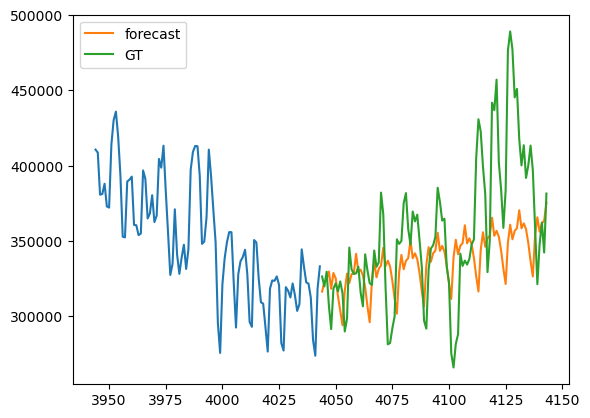

In [13]:
import matplotlib.pyplot as plt

print(forecast)
plt.plot(tmp_data[-100:])
plt.plot(forecast, label='forecast')
plt.plot(list(forecast.index), val_data_list[0][0][:len(forecast)], label='GT')
plt.legend()
plt.show()

In [22]:
from torchmetrics.regression import SymmetricMeanAbsolutePercentageError as SMAPE, MeanAbsolutePercentageError as MAPE, R2Score as R2

def smape(A, F):
    return 100 / len(A) * np.sum(np.abs(F - A) / (np.abs(A) + np.abs(F)))

smape((val_data_list[0][0][:len(forecast)]), forecast)

4.52941448864653